In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Importing dataset and separating train and target data
df = pd.read_csv('WineQT.csv', index_col = 'Id')

In [3]:
#Check for null values
df[df.columns[df.isnull().sum() > 0]].isna().mean()*100

Series([], dtype: float64)

No null values in the dataset

In [4]:
#Check for low variance features
vt = VarianceThreshold()
print(len(pd.DataFrame(vt.fit_transform(df)).columns), len(df.columns))

12 12


No low valence features

In [5]:
#Check the correlation of all features with the target variable
df.corr()['quality']

fixed acidity           0.121970
volatile acidity       -0.407394
citric acid             0.240821
residual sugar          0.022002
chlorides              -0.124085
free sulfur dioxide    -0.063260
total sulfur dioxide   -0.183339
density                -0.175208
pH                     -0.052453
sulphates               0.257710
alcohol                 0.484866
quality                 1.000000
Name: quality, dtype: float64

In [6]:
#Drop columns which have low correlation (<0.1) with target variable
df = df.drop(['pH', 'residual sugar', 'free sulfur dioxide'], axis = 1)

In [7]:
#Splitting data into train and test sets
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
#Scaling the data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
#Choosing classifier models
models = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]

In [10]:
#Fitting data
results = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append(str(model).replace("()", "") + " score: " + str(accuracy_score(y_test, y_pred)))
results

['LogisticRegression score: 0.6331877729257642',
 'KNeighborsClassifier score: 0.5545851528384279',
 'SVC score: 0.6331877729257642',
 'DecisionTreeClassifier score: 0.5458515283842795',
 'RandomForestClassifier score: 0.6768558951965066']

The random forest classifier seemed to work the best for this data

In [11]:
rf = RandomForestClassifier()
print(rf.fit(X_train, y_train).feature_importances_, df.columns)

[0.10000112 0.13346541 0.10788632 0.10943675 0.12719299 0.12556267
 0.14811754 0.14833721] Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


All features seem to have similar importance

In [12]:
#Let's try to apply PCA and see if it improves the score
from sklearn.decomposition import PCA
sar = {}
for component in range(1, 9):
    pca = PCA(n_components = component)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    model = RandomForestClassifier()
    model.fit(X_train_PCA, y_train)
    y_pred = model.predict(X_test_PCA)
    acc = accuracy_score(y_test, y_pred)
    sar.update({'Number of components: ' + str(component) : acc})
sar

{'Number of components: 1': 0.4890829694323144,
 'Number of components: 2': 0.5152838427947598,
 'Number of components: 3': 0.6506550218340611,
 'Number of components: 4': 0.6593886462882096,
 'Number of components: 5': 0.6593886462882096,
 'Number of components: 6': 0.6724890829694323,
 'Number of components: 7': 0.6550218340611353,
 'Number of components: 8': 0.6812227074235808}

Text(0.5, 1.0, 'Model performance with PCA applied')

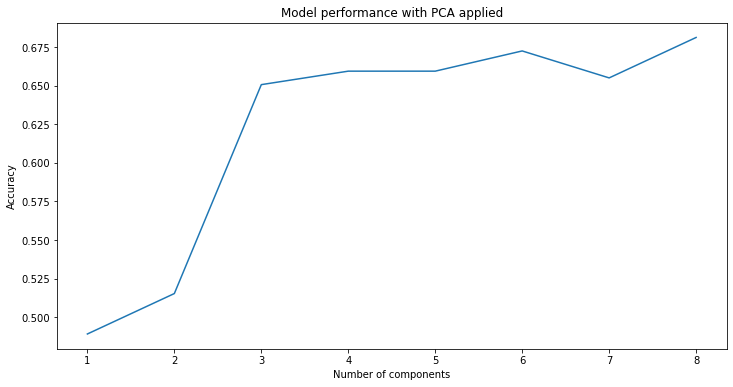

In [13]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure(figsize=(12, 6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(y = list(sar.values()), x = range(1, 9))
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Model performance with PCA applied')

Best score with PCA applied was having 8 components, but it didn't seem to improve the score for our best model

In [14]:
#Let's try to apply LDA and see if it improves the score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sar = {}
for component in range(1, 6):
    lda = LDA(n_components = component)
    X_train_LDA = lda.fit_transform(X_train, y_train)
    X_test_LDA = lda.transform(X_test)
    model = RandomForestClassifier()
    model.fit(X_train_LDA, y_train)
    y_pred = model.predict(X_test_LDA)
    acc = accuracy_score(y_test, y_pred)
    sar.update({'Number of components: ' + str(component) : acc})
sar

{'Number of components: 1': 0.5458515283842795,
 'Number of components: 2': 0.6462882096069869,
 'Number of components: 3': 0.6855895196506551,
 'Number of components: 4': 0.6593886462882096,
 'Number of components: 5': 0.6899563318777293}

Text(0.5, 1.0, 'Model performance with LDA applied')

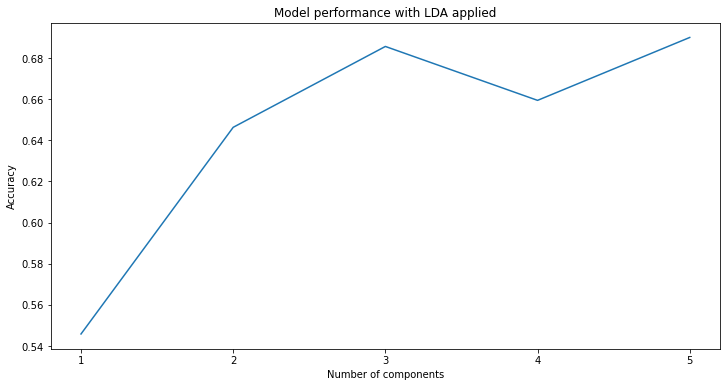

In [15]:
ax = plt.figure(figsize=(12, 6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(y = list(sar.values()), x = range(1, 6))
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Model performance with LDA applied')

Along with PCA, the LDA doesn't seem to improve the score

In [16]:
#Let's try to apply Kernel PCA and see if it improves the score
from sklearn.decomposition import KernelPCA
sar = {}
for component in range(1, 9):
    kpca = KernelPCA(n_components = component, kernel = 'cosine')
    X_train_KPCA = pca.fit_transform(X_train)
    X_test_KPCA = pca.transform(X_test)
    model = RandomForestClassifier()
    model.fit(X_train_PCA, y_train)
    y_pred = model.predict(X_test_PCA)
    acc = accuracy_score(y_test, y_pred)
    sar.update({'Number of components: ' + str(component) : acc})
sar

{'Number of components: 1': 0.6812227074235808,
 'Number of components: 2': 0.6812227074235808,
 'Number of components: 3': 0.6593886462882096,
 'Number of components: 4': 0.6768558951965066,
 'Number of components: 5': 0.6593886462882096,
 'Number of components: 6': 0.6812227074235808,
 'Number of components: 7': 0.6681222707423581,
 'Number of components: 8': 0.6812227074235808}

Text(0.5, 1.0, 'Model performance with Kernel PCA applied')

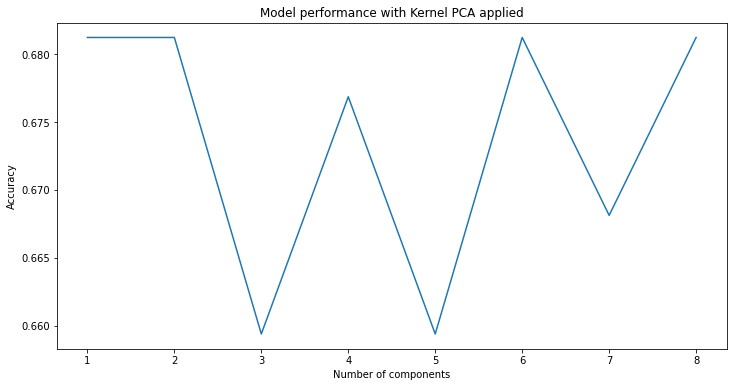

In [17]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure(figsize=(12, 6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(y = list(sar.values()), x = range(1, 9))
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Model performance with Kernel PCA applied')

In some individual cases dimensionality reduction improved the score by ~1%, but overall it didn't seem to improve the score drastically 

Let's try to improve our random forest classifier model

In [18]:
#Applying grid search to find the best model parameters
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [2, 10, 25, 50], 'criterion': ['gini'], 'max_depth' : [2, 5, 10, 20]},
              {'n_estimators': [120, 130, 140, 150], 'criterion': ['entropy'], 'max_depth' : [20, 25, 30], 'min_samples_split' : [2, 3, 4, 5]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Accuracy: 67.94 %
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 140}


After several grid search attempts the best parameters were these: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 120}.
Bearing this in mind, let's try to apply modified grid search again

In [19]:
#Applying grid search to find the best model parameters
classifier = RandomForestClassifier(criterion = 'entropy', max_depth = 25, min_samples_split = 4, n_estimators = 120)
classifier.fit(X_train, y_train)
from sklearn.model_selection import GridSearchCV
parameters = [{'min_samples_leaf': [1, 2, 3], 'max_leaf_nodes': [None, 1, 2], 'max_samples': [None, 1, 2]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Accuracy: 67.40 %
Best Parameters: {'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1}


Looks like these parameters were fitted best at their default values

In [20]:
#Let's train the model with the best parameters again
model = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_split=4, n_estimators=120)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7030567685589519

The best score I could get from this model was 71.6%

In [21]:
#Let's try to apply k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 67.73 %
Standard Deviation: 6.13 %


The k-fold cross validation didn't improve the score. The score of only ~70% may be due to small dataset and/or too few features